In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import helper
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive/')
path_data = 'drive/My Drive/turtle_recall/images/'

Mounted at /content/drive/


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder(path_data, transform= transform)

In [ ]:
mean = 0.
std = 0.
nb_samples = 0.
# Iterate over the images in the dataset
for data, _ in dataset:
    # Get the shape of the data tensor
    shape = data.shape
    # Flatten the tensor to a 1D array
    data = data.view(data.size(0), -1)
    # Calculate the mean and standard deviation of the pixel values
    mean += data.mean(1)
    std += data.std(1)
    # Increment the sample count
    nb_samples += data.size(0)

# Calculate the mean and standard deviation of the entire dataset
mean /= nb_samples
std /= nb_samples

# Print the results
print("Mean:", mean)
print("Standard deviation:", std)

Mean: tensor([0.1313, 0.1132, 0.0950])
Standard deviation: tensor([0.0659, 0.0615, 0.0587])


In [ ]:
#Mean: tensor([0.1313, 0.1132, 0.0950])
#Standard deviation: tensor([0.0659, 0.0615, 0.0587])

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])


In [ ]:
dataset = torchvision.datasets.ImageFolder(path_data, transform=transform)

In [ ]:
train_set, test_set = torch.utils.data.random_split(dataset, [1006, 112])

In [ ]:
# Create a data loader for the training set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)

# Create a data loader for the test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

# Create a dictionary of data loaders
dataloaders = {'train': train_loader, 'test': test_loader}

In [ ]:
data_iter = iter(dataloaders['train'])
images, labels = next(data_iter)

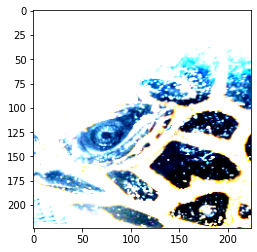

In [ ]:
plt.imshow(  images[7].permute(1, 2, 0)  )

In [ ]:
model_name = 'resnet'

# Number of classes in the dataset
num_classes = len(dataset.classes)
print(f"number of turtles: {num_classes}")

# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Number of epochs to train for
num_epochs = 50
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

number of turtles: 99


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      for phase in ['train', 'test']:
          if phase == 'train':
              model.train()  # Set model to training mode
          else:
              model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              optimizer.zero_grad()

              with torch.set_grad_enabled(phase == 'train'):

                  if is_inception and phase == 'train':

                      outputs, aux_outputs = model(inputs)
                      loss1 = criterion(outputs, labels)
                      loss2 = criterion(aux_outputs, labels)
                      loss = loss1 + 0.4*loss2
                  else:
                      outputs = model(inputs)
                      loss = criterion(outputs, labels)

                  _, preds = torch.max(outputs, 1)


                  if phase == 'train':
                      loss.backward()
                      optimizer.step()

           
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


          if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
          if phase == 'test':
              val_acc_history.append(epoch_acc)
    
    # Use the scheduler to adjust the learning rate
      scheduler.step(epoch_loss)
      print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# let's start by initialising the model

def initialize_model(num_classes, feature_extract, use_pretrained=True):

    model_ft = models.resnet50(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#model_ft.fc = nn.Linear(512, num_classes)

In [ ]:
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [ ]:
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)


Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)

In [ ]:
import time
import copy
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 3.2451 Acc: 0.3400
test Loss: 3.9979 Acc: 0.1339

Epoch 1/49
----------
train Loss: 3.2105 Acc: 0.3598
test Loss: 3.9746 Acc: 0.1339

Epoch 2/49
----------
train Loss: 3.1505 Acc: 0.3837
test Loss: 3.9521 Acc: 0.1429

Epoch 3/49
----------
train Loss: 3.1030 Acc: 0.4095
test Loss: 3.9343 Acc: 0.1607

Epoch 4/49
----------
train Loss: 3.0456 Acc: 0.4135
test Loss: 3.9372 Acc: 0.1607

Epoch 5/49
----------
train Loss: 2.9987 Acc: 0.4324
test Loss: 3.9123 Acc: 0.1339

Epoch 6/49
----------
train Loss: 2.9426 Acc: 0.4364
test Loss: 3.8914 Acc: 0.1696

Epoch 7/49
----------
train Loss: 2.9009 Acc: 0.4592
test Loss: 3.8736 Acc: 0.1429

Epoch 8/49
----------
train Loss: 2.8513 Acc: 0.4761
test Loss: 3.8627 Acc: 0.1696

Epoch 9/49
----------
train Loss: 2.8076 Acc: 0.4791
test Loss: 3.8611 Acc: 0.1696

Epoch 10/49
----------
train Loss: 2.7667 Acc: 0.5159
test Loss: 3.8614 Acc: 0.1786

Epoch 11/49
----------
train Loss: 2.7222 Acc: 0.5070
test Loss: 3.8451 Acc